# Overcome complex terrain with a hybrid controller

**Summary**: In this tutorial, we will illustrate how the CPG-based and rule-based controllers fail to produce robust locomotion over complex terrain. We will also build a CPG + sensory feedback hybrid controller to drive more robust walking.

In the *[Controlling locomotion with CPGs](https://neuromechfly.org/tutorials/cpg_controller.html)* and *[Rule-based controller](https://neuromechfly.org/tutorials/rule_based_controller.html)* tutorials, we have demonstrated how different control strategies can lead to effective walking over simple, flat terrain. However, animals locomote over complex surfaces. To overcome these complex terrain, animals likely use a combination of CPGs and sensory feedback to produce agile, adaptive body kinematics. To enable the exploration of how sensory feedback can facilitate motor control over rugged surfaces, we have developed three rugged terrain types that complement our baseline smooth terrain: one with gaps perpendicular to the initial heading of the fly, one with blocks of variable height, and one that is a mixture of these two. Using these new terrain types, we will now demonstrate how one can examine the efficacy of different bioinspired control strategies.


## Defining the arena

The environment that the fly is situated in is defined by the Arena class. So far, we have been using the default terrain: ``FlatTerrain``. Some other arenas are also included in FlyGym package, inlcuding ``GappedTerrain``, ``BlocksTerrain``, and ``MixedTerrain``. In future tutorials, we will introduce more arenas with sensory (visual, olfactory) features. The user can define custom arenas by inheriting from the ``flygym.mujoco.arena.BaseArena`` abstract class.

Let's start by defining a couple of terrains:

In [1]:
from flygym.mujoco.arena import FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain


def get_arena(arena_type):
    if arena_type == "flat":
        return FlatTerrain()
    elif arena_type == "gapped":
        return GappedTerrain()
    elif arena_type == "blocks":
        return BlocksTerrain()
    elif arena_type == "mixed":
        return MixedTerrain()
    else:
        raise ValueError(f"Unknown arena type: {arena_type}")

Let's put a fly in each of these terrains, run 0.01 seconds of simulation so the fly can stabilize on the floor, and visualize a snapshot to see how the fly looks like over these terrain types:

4it [00:13,  3.29s/it]


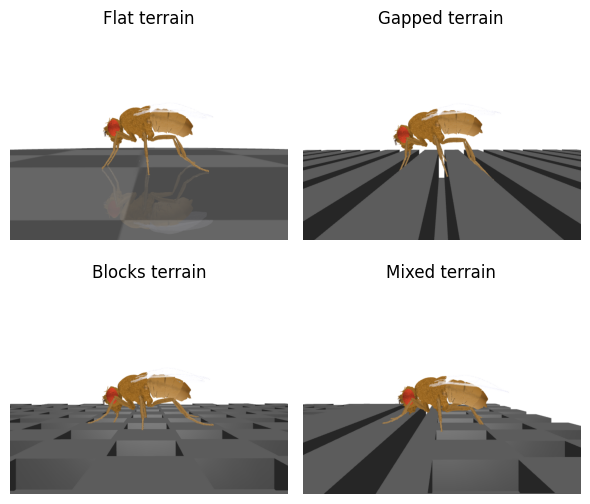

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.examples import PreprogrammedSteps

preprogrammed_steps = PreprogrammedSteps()  # we will use the neutral pose from this

sim_params = Parameters(
    timestep=1e-4,
    enable_adhesion=True,
    render_fps=101,
    render_playspeed=1,
    render_playspeed_text=False,
)

fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)
terrain_types = ["flat", "gapped", "blocks", "mixed"]
for i, terrain_type in tqdm(enumerate(terrain_types)):
    ax = axs.flat[i]
    terrain = get_arena(terrain_type)
    nmf = NeuroMechFly(sim_params=sim_params, arena=terrain, spawn_pos=(0, 0, 0.2))
    nmf.reset()
    for _ in range(100):
        action = {
            "joints": preprogrammed_steps.default_pose,
            "adhesion": np.ones(6, dtype=np.int32),
        }
        nmf.step(action)
        nmf.render()
    ax.imshow(nmf._frames[-1])
    ax.axis("off")
    ax.set_title(f"{terrain_type.title()} terrain")

fig.savefig("./outputs/complex_terrain_overview.png")

## Basic CPG-based and rule-based controllers

Does the CPG-based and rule-based controller work over complex terrain? Let's run 0.5 seconds of simulation using each of the controllers on each of the terrain types:

In [3]:
from flygym.mujoco.examples.cpg_controller import CPGNetwork, run_cpg_simulation
from flygym.mujoco.examples.rule_based_controller import (
    RuleBasedSteppingCoordinator,
    construct_rules_graph,
    run_rule_based_simulation,
)

run_time = 0.5
timestep = 1e-4

for controller_name in ["CPG-based", "Rule-based"]:
    for terrain_name in terrain_types:
        print(f"* Running {controller_name} controller on {terrain_name} terrain")

        terrain = get_arena(terrain_name)

        # Initialize the simulation
        sim_params = Parameters(
            timestep=1e-4,
            render_mode="saved",
            render_playspeed=0.1,
            enable_adhesion=True,
            draw_adhesion=True,
        )
        nmf = NeuroMechFly(sim_params=sim_params, arena=terrain, spawn_pos=(0, 0, 0.2))

        if controller_name == "CPG-based":
            intrinsic_freqs = np.ones(6) * 12
            intrinsic_amps = np.ones(6) * 1
            phase_biases = np.pi * np.array(
                [
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                ]
            )
            coupling_weights = (phase_biases > 0) * 10
            convergence_coefs = np.ones(6) * 20
            cpg_network = CPGNetwork(
                timestep=timestep,
                intrinsic_freqs=intrinsic_freqs,
                intrinsic_amps=intrinsic_amps,
                coupling_weights=coupling_weights,
                phase_biases=phase_biases,
                convergence_coefs=convergence_coefs,
            )
            run_cpg_simulation(nmf, cpg_network, preprogrammed_steps, run_time)
        elif controller_name == "Rule-based":
            weights = {
                "rule1": -10,
                "rule2_ipsi": 2.5,
                "rule2_contra": 1,
                "rule3_ipsi": 3.0,
                "rule3_contra": 2.0,
            }
            rules_graph = construct_rules_graph()
            controller = RuleBasedSteppingCoordinator(
                timestep=timestep,
                rules_graph=rules_graph,
                weights=weights,
                preprogrammed_steps=preprogrammed_steps,
            )
            run_rule_based_simulation(nmf, controller, run_time)
        else:
            raise ValueError(f"Unknown controller: {controller}")

        x_pos = nmf.get_observation()["fly"][0, 0]
        print(f"Final x position: {x_pos:.4f} mm")

        nmf.save_video(f"./outputs/{controller_name}_{terrain_name}.mp4")

* Running CPG-based controller on flat terrain


100%|██████████| 5000/5000 [00:13<00:00, 371.84it/s]


Final x position: 4.9144 mm
* Running CPG-based controller on gapped terrain


100%|██████████| 5000/5000 [00:11<00:00, 440.77it/s]


Final x position: 2.9075 mm
* Running CPG-based controller on blocks terrain


100%|██████████| 5000/5000 [00:10<00:00, 470.04it/s]


Final x position: 4.2828 mm
* Running CPG-based controller on mixed terrain


100%|██████████| 5000/5000 [00:11<00:00, 449.06it/s]


Final x position: 4.0499 mm
* Running Rule-based controller on flat terrain


100%|██████████| 5000/5000 [00:18<00:00, 272.57it/s]


Final x position: 2.6169 mm
* Running Rule-based controller on gapped terrain


100%|██████████| 5000/5000 [00:12<00:00, 413.62it/s]


Final x position: 1.0374 mm
* Running Rule-based controller on blocks terrain


100%|██████████| 5000/5000 [00:13<00:00, 377.23it/s]


Final x position: 2.0600 mm
* Running Rule-based controller on mixed terrain


100%|██████████| 5000/5000 [00:12<00:00, 407.71it/s]


Final x position: 2.3158 mm


Though we have only tested n=1 initial condition (spawn position, controller) per case, we can already see hints that the basic CPG-based and rule-based controllers might not be so robust over complex terrain. In fact, if we run n=20 initial conditions for 1 second each, we get something like this as reported in the NeuroMechFly 2.0 paper:

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/cpg_rule_based_comparison.png?raw=true" alt="cpg_rule_based_comparison" width="800"/>

We can check some of the failed examples:

*CPG-based controller over gapped terrain:*

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/CPG-based_gapped.mp4" type="video/mp4">
</video>

*Rule-based controller over gapped terrain:*

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/Rule-based_gapped.mp4" type="video/mp4">
</video>

In the next section, we will show that by combining CPGs with sensory feedback, we can build a more robust controller.

## Building a hybrid controller

Now, we will build a hybrid controller integrating feedforward oscillators with feedback-based correction mechanisms in case any leg gets stuck. As described in the NeuroMechFly 2.0 paper, we will detect the following conditions:
1. **Retraction:** In principle, with the tripod gait, there should always be three legs that are on the ground. Therefore, if any leg is extended further than the third most extended leg in the z direction, this leg might be stuck in a hole. In this case, this leg will be lifted further to recover it from the stuck position.
2. **Stumbling:** In principle, only the tip of the tarsus of each leg should collide with the ground. Therefore, when the tibia and upper part of the tarsus (tarsus 1–2) collide with the ground, resulting in an above-threshold force against the direction of the fly's heading, we consider that the fly is stumbling. We lift the stumbling leg further to prevent it from getting stuck.

To implement these rules, we will create a variable for each rule that keeps track of the extent the leg should be lifted:

In [4]:
retraction_correction = np.zeros(6)
stumbling_correction = np.zeros(6)

We will also define vector representing how each DoF should be adjusted to implement the leg lift. We will call this $\vec{v}_\text{leg}$.

In [5]:
correction_vectors = {
    # "leg pos": (Coxa, Coxa_roll, Coxa_yaw, Femur, Fimur_roll, Tibia, Tarsus1)
    # unit: radian
    "F": np.array([0, 0, 0, -0.02, 0, 0.016, 0]),
    "M": np.array([-0.015, 0, 0, 0.004, 0, 0.01, -0.008]),
    "H": np.array([0, 0, 0, -0.01, 0, 0.005, 0]),
}

That is, when the leg should be lifted further, we will increment the joint angles on this leg by $\vec{v}_\text{leg}$ scaled by a factor defining the extent of correction. When the condition is no longer met, we will reduce the correction term until it reaches zero (ie. when there is no adjustment) so that the target angles as predicted by the CPGs are directly applied to the simulator.

Next, we need to define the factor defining the extent of correction. Recall that we will progressively lift the leg when an adjustment is necessary. Therefore, let's also define the rate of adjustment $k_\text{inc}$ when the condition is met and the rate of recovery $k_\text{dec}$ when the condition is no longer met:

In [6]:
correction_rates = {
    # "rule": (increment rate, decrement rate). unit: 1/sec
    "retraction": (500, 1000 / 3),
    "stumbling": (2000, 500),
}

Concretely, we will initialize the correction amount $c$ to 0. This variable is unitless. For every $t$ amount of time that the condition is met, we increment $c$ by $k_\text{inc}t$ where $k_\text{inc}$ is appropriate correction rate. Similarly, for every $t$ amount of time that the condition is no longer met, we will decrement $c$ by $k_\text{dec}t$ until it reaches 0. We will therefore adjust the leg joint angles by adding $c\vec{v}_\text{leg}$ to it.

We should also define a threshold for the stumbling force. Note that a negative number indicates a force against the direction that the fly is facing:

In [7]:
stumbling_force_threshold = -1

Next, we will define the underlying CPG network as we did in the [tuotorial on the CPG controller](https://neuromechfly.org/tutorials/cpg_controller.html):

In [8]:
run_time = 1
timestep = 1e-4

# Define leg raise correction vectors
correction_vectors = {
    # "leg pos": (Coxa, Coxa_roll, Coxa_yaw, Femur, Fimur_roll, Tibia, Tarsus1)
    "F": np.array([0, 0, 0, -0.02, 0, 0.016, 0]),
    "M": np.array([-0.015, 0, 0, 0.004, 0, 0.01, -0.008]),
    "H": np.array([0, 0, 0, -0.01, 0, 0.005, 0]),
}

# Define leg raise rates
correction_rates = {"retraction": (500, 1000 / 3), "stumbling": (2000, 500)}

# Initialize CPG network
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20
cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

Similarly, let's define the preprogrammed steps:

In [9]:
# Initialize preprogrammed steps
preprogrammed_steps = PreprogrammedSteps()

... and the NeuroMechFly simulation over mixed terrain. We will enable contact detection at all tibia and tarsus segments for the stumbling detection:

In [10]:
# Initialize NeuroMechFly simulation
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    enable_adhesion=True,
    draw_adhesion=True,
)
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in preprogrammed_steps.legs
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
arena = MixedTerrain()
nmf = NeuroMechFly(
    sim_params=sim_params,
    arena=arena,
    init_pose="stretch",
    control="position",
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)

Let's build a dictionary containing the indices of the contact sensors on each leg that are used for stumbling detection:

In [11]:
detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
for i, sensor_name in enumerate(nmf.contact_sensor_placements):
    leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
    segment = sensor_name.split("/")[1][2:]
    if segment in detected_segments:
        stumbling_sensors[leg].append(i)
stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

As a sanity check, let's make sure that the number of stumbling sensors per leg is as expected:

In [12]:
if any(v.size != len(detected_segments) for v in stumbling_sensors.values()):
    raise RuntimeError(
        "Contact detection must be enabled for all tibia, tarsus1, and tarsus2 "
        "segments for stumbling detection."
    )

We are now ready to write the main simulation loop. This is a bit complicated. We will first implement and execute the whole loop before explaining its components:

In [13]:
obs, info = nmf.reset()
for _ in trange(int(run_time / nmf.sim_params.timestep)):
    # retraction rule: is any leg stuck in a hole and needs to be retracted?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
    if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
    else:
        leg_to_correct_retraction = None

    cpg_network.step()
    joints_angles = []
    adhesion_onoff = []
    for i, leg in enumerate(preprogrammed_steps.legs):
        # update retraction correction amounts
        if i == leg_to_correct_retraction:  # lift leg
            increment = correction_rates["retraction"][0] * nmf.timestep
            retraction_correction[i] += increment
            nmf.change_segment_color(f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * nmf.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Tibia", (0.5, 0.5, 0.5, 1))

        # update stumbling correction amounts
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * nmf.timestep
            stumbling_correction[i] += increment
            nmf.change_segment_color(f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * nmf.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Femur", (0.5, 0.5, 0.5, 1))

        # retraction correction has priority
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
        else:
            net_correction = stumbling_correction[i]

        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)

        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )
        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

100%|██████████| 10000/10000 [00:23<00:00, 432.09it/s]


Within each simulation step, we first check whether the retraction rule is met. Again, this depends one whether any leg is extended further than the third most extended leg in the z direction by a margin of 0.05 mm. This margin is important because the contact calculation in the physics simulator is not perfect, and sometimes the leg penetrates into the floor by a small amount. If two legs meet this condition, only the most extended leg is corrected:

```Python
    # retraction rule: is any leg stuck in a hole and needs to be retracted?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
    if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
    else:
        leg_to_correct_retraction = None
```

Then, have an inner loop that iterates over all legs. Here, the joint angles and the adhesion on/off signal are calculated. We first update the correction amount $c$ for the retraction rule:

```Python
        # update retraction correction amounts
        if i == leg_to_correct_retraction:  # lift leg
            increment = correction_rates["retraction"][0] * nmf.timestep
            retraction_correction[i] += increment
            nmf.change_segment_color(f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * nmf.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Tibia", (0.5, 0.5, 0.5, 1))
```

Similarly, we update the correction amount $c$ for the stumbling rule:

```Python
        # update stumbling correction amounts
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * nmf.timestep
            stumbling_correction[i] += increment
            nmf.change_segment_color(f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * nmf.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            nmf.change_segment_color(f"{leg}Femur", (0.5, 0.5, 0.5, 1))
```

In case both rules are active for the same leg, we only apply the retraction correction:

```Python
        # retraction correction has priority
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
        else:
            net_correction = stumbling_correction[i]
```

Now, let's get the naive joint angles based on the CPG phase and the preprogrammed step. Then, we apply the lifting correction:

```Python
        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)
```

Finally, we can get the adhesion on/off signal based on the leg phase as well:

```Python
        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )
        adhesion_onoff.append(my_adhesion_onoff)
```

We now have all we need to construct the action and feed it into the NeuroMechFly simulation. Don't forget to call `.render()` too so the video can be recorded correctly.

```Python
    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
```


Let's visualize the result:

In [14]:
nmf.save_video("./outputs/hybrid_controller_mixed_terrain.mp4")

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/hybrid_controller_mixed_terrain.mp4" type="video/mp4">
</video>

From a sample size of 1, this looks better than the CPG-only and rules-only controllers. Indeed, we ran n=20 simulations for each controller over each terrain type with different initial conditions and obtained the following results, indicating that the hybrid controller integrating oscillator states with sensory feedback outperforms the other basic controllers (see the NeuroMechFly 2.0 paper for details):

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/cpg_rule_based_hybrid_comparison.png?raw=true" alt="cpg_rule_based_comparison" width="800"/>

This hybrid controller is still quite restricted and heavily hand-tuned. Nonetheless, these results demonstrate how rugged terrain can expose failure modes of controllers that otherwise work well on flat terrain, and how one can use NeuroMechFly to benchmark different control strategies that go beyond the classical dichotomy of CPGs vs. sensory feedback-based control.

In the next tutorial, we will refactor our hybrid controller code into a Python class that implements the Gym interface. This will show how one can build controller models at different levels of abstraction with variable amounts of preprogrammed computation.